In [1]:
import torch
from IPython.display import display
from PIL import Image
from transformers import ColPaliForRetrieval, ColPaliProcessor
from peft import PeftModel


def get_torch_device(device: str = "auto") -> str:
    """
    Returns the device (string) to be used by PyTorch.

    `device` arg defaults to "auto" which will use:
    - "cuda:0" if available
    - else "mps" if available
    - else "cpu".
    """
    if device == "auto":
        if torch.cuda.is_available():
            device = "cuda:0"
        elif torch.backends.mps.is_available():  # for Apple Silicon
            device = "mps"
        else:
            device = "cpu"

    return device

def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    # Calculate the scaling factor
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    # Resize the image
    scaled_image = image.resize((new_width, new_height))

    return scaled_image

/home/linux/anaconda3/envs/colpali/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = get_torch_device("auto")

print(f"Using device: {device}")


# 加载 tokenizer 和基座模型
base_model_path = "/home/linux/yyj/colpali/colpali_v1.2_hf"
base_model = ColPaliForRetrieval.from_pretrained(
    base_model_path,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",
)
# 加载微调后的 adapter（LoRA 权重）
adapter_path = "/home/linux/yyj/colpali/wiky_city_zh_0528"
model = PeftModel.from_pretrained(base_model, adapter_path)
processor = ColPaliProcessor.from_pretrained(adapter_path)


Using device: cuda:0


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


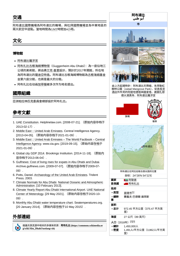

In [34]:
# Load the image and query inputs
image_filepath = "/home/linux/yyj/colpali/test_model.png"

image = [Image.open(image_filepath)]

queries = ["文化"]

# Preview the input images
for image in image:
    display(scale_image(image, 256))

In [35]:
# Preprocess inputs
batch_images = processor(images=image).to(model.device)
batch_queries = processor(text=queries).to(model.device)

# Forward pass
with torch.no_grad():
    image_embeddings = model(**batch_images).embeddings
    query_embeddings = model(**batch_queries).embeddings
print(image_embeddings)
print(query_embeddings)

tensor([[[ 0.0103,  0.0144,  0.1270,  ..., -0.0996,  0.1338, -0.0845],
         [ 0.1436, -0.0347,  0.0284,  ..., -0.1177,  0.0466,  0.0118],
         [ 0.0481, -0.0178,  0.0236,  ...,  0.1240,  0.0732,  0.1143],
         ...,
         [-0.1279,  0.0081,  0.1426,  ...,  0.0361,  0.0381,  0.0791],
         [-0.1079,  0.1099,  0.1289,  ...,  0.1079, -0.0137, -0.1030],
         [-0.1206,  0.0747,  0.2334,  ...,  0.0752, -0.0801, -0.1270]]],
       device='cuda:0', dtype=torch.bfloat16)
tensor([[[ 0.1523, -0.0014,  0.1162,  ..., -0.0267, -0.0981, -0.0361],
         [-0.1040, -0.1025,  0.0608,  ..., -0.0493, -0.0845,  0.0957],
         [-0.0447,  0.0747,  0.0967,  ..., -0.0172, -0.1045,  0.0150],
         ...,
         [ 0.1128,  0.1943, -0.0635,  ...,  0.0198, -0.1494,  0.0791],
         [ 0.1152,  0.2041, -0.0791,  ...,  0.0099, -0.1436,  0.0796],
         [ 0.0679,  0.1768, -0.0747,  ...,  0.0422, -0.1787,  0.0427]]],
       device='cuda:0', dtype=torch.bfloat16)


In [36]:
scores = processor.score_retrieval(query_embeddings, image_embeddings)  # (n_queries, n_images)

scores

tensor([[8.]], dtype=torch.bfloat16)

In [37]:
import pprint
from typing import Tuple

import matplotlib.pyplot as plt
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)
from transformers import BatchFeature, ProcessorMixin


def get_n_patches(processor: ProcessorMixin, patch_size: int) -> Tuple[int, int]:
    n_patches_x = processor.image_processor.size["width"] // patch_size
    n_patches_y = processor.image_processor.size["height"] // patch_size
    return n_patches_x, n_patches_y


def get_image_mask(processor: ProcessorMixin, batch_images: BatchFeature) -> torch.Tensor:
    return batch_images.input_ids == processor.image_token_id

In [38]:
image = image
query = queries[0]
processed_query = processor(text=[query]).to(model.device)

image_embedding = image_embeddings[[0], ...]
query_embedding = query_embeddings[[0], ...]

In [39]:
# Get the number of patches and the image mask
n_patches = get_n_patches(processor=processor, patch_size=model.vlm.vision_tower.config.patch_size)
image_mask = get_image_mask(processor=processor, batch_images=batch_images)

# Get the similarity maps for the first image in the batch
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=image_embedding,
    query_embeddings=query_embedding,
    n_patches=n_patches,
    image_mask=image_mask,
)
similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)

# Use this cell output to choose a token using its index
query_content = processor.decode(processed_query.input_ids[0]).replace(processor.tokenizer.pad_token, "")
query_content = query_content.replace(processor.query_augmentation_token, "").strip()
query_tokens = processor.tokenizer.tokenize(query_content)

pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

{0: '<bos>', 1: 'Question', 2: ':', 3: '▁文化'}


Selected token: `▁文化`


/home/linux/anaconda3/envs/colpali/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/linux/anaconda3/envs/colpali/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


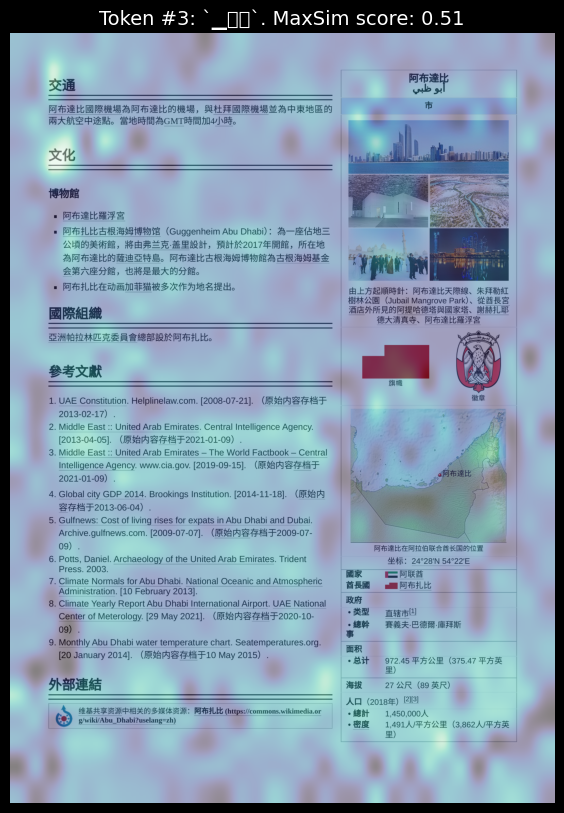

In [40]:
# Choose a token using its index
token_idx = 3  # e.g. if "12: '▁Kazakhstan',", set 12 to choose the token 'Kazakhstan'

print(f"Selected token: `{query_tokens[token_idx]}`")

# Retrieve the similarity map for the chosen token
current_similarity_map = similarity_maps[token_idx]  # (n_patches_x, n_patches_y)

fig, ax = plot_similarity_map(
    image=image,
    similarity_map=current_similarity_map,
    figsize=(8, 8),
    show_colorbar=False,
)

max_sim_score = similarity_maps[token_idx, :, :].max().item()
ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

fig

In [ ]:
plots = plot_all_similarity_maps(
    image=image,
    query_tokens=query_tokens,
    similarity_maps=similarity_maps,
    figsize=(8, 8),
    show_colorbar=False,
    add_title=True,
)

for idx, (fig, ax) in enumerate(plots):
    savepath = f"similarity_map_{idx}.png"
    fig.savefig(savepath, bbox_inches="tight")
    print(f"Similarity map for token `{query_tokens[idx]}` saved at `{savepath}`")

plt.close("all")